# Load Data

In [1]:
import load_data
df = load_data.load_county_level(data_dir='data')
keys = df.keys()

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [2]:
import numpy as np
import torch as th
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
# for i in range(87, 216):
for i in range(132, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
# for i in range(218, 347):
for i in range(263, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 96471 #fixed the population value for Erie

In [35]:
def true_params(cases, recovered, deaths, population):
    X = cases
    R = recovered + deaths

    n = np.array([population] * len(X), dtype=np.float64)

    S = n - X - R

    X_diff = np.array([X[:-1], X[1:]], dtype=np.float64).T
    R_diff = np.array([R[:-1], R[1:]], dtype=np.float64).T

    gamma = (R[1:] - R[:-1]) / (X[:-1] + 1)
    beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1]) + 1)
    return gamma, beta

In [36]:
gamma_lst = []
beta_lst = []
recovered = np.zeros(len(cases[0]))
for i in range(len(cases)):
    gamma, beta = true_params(cases[i], recovered, deaths[i], pop[i])
    gamma_lst.append(gamma)
    beta_lst.append(beta)
gamma_lst = np.stack(gamma_lst,0)
beta_lst = np.stack(beta_lst,0)

In [5]:
#keys = df.keys()
#for i, val in enumerate(df.iloc[4]):
#    print(i, '\t', keys[i], '\t', val)

In [40]:
import torch as th

out_size = 1
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 1

train_past_cases_1d = []
train_past_deaths_1d = []
train_past_gamma_1d = []
train_past_beta_1d = []
train_labels_cases_1d = []
train_labels_deaths_1d = []
train_labels_gamma_1d = []
train_labels_beta_1d = []

# for start in range(14):
#     end = start + in_len + out_len - 1
#     end_begin = end - out_len
#     train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
#     train_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
#     train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
#     train_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))

# for start in range(14, train_valid_split - in_len - out_len + 1):
#     end = start + in_len + out_len - 1
#     end_begin = end - out_len
#     train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
#     train_past_deaths_1d.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
#     train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
#     train_labels_deaths_1d.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))

for start in range(train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    train_past_deaths_1d.append(th.tensor(deaths[:,start:end_begin], dtype=th.float32))
    train_past_gamma_1d.append(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32))
    train_past_beta_1d.append(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32))
    train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    train_labels_deaths_1d.append(th.tensor(deaths[:,end_begin:end], dtype=th.float32))
    train_labels_gamma_1d.append(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32))
    train_labels_beta_1d.append(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32))


valid_past_cases_1d = []
valid_past_deaths_1d = []
valid_past_gamma_1d = []
valid_past_beta_1d = []
valid_labels_cases_1d = []
valid_labels_deaths_1d = []
valid_labels_gamma_1d = []
valid_labels_beta_1d = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    valid_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    valid_past_gamma_1d.append(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32))
    valid_past_beta_1d.append(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32))
    valid_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    valid_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    valid_labels_gamma_1d.append(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32))
    valid_labels_beta_1d.append(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32))
    
test_past_cases_1d = []
test_past_deaths_1d = []
test_past_gamma_1d = []
test_past_beta_1d = []
test_labels_cases_1d = []
test_labels_deaths_1d = []
test_labels_gamma_1d = []
test_labels_beta_1d = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    test_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    test_past_gamma_1d.append(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32))
    test_past_beta_1d.append(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32))
    test_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    test_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    test_labels_gamma_1d.append(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32))
    test_labels_beta_1d.append(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32))

In [48]:
train_labels_Sacramento = []
for i in range(34):
    train_labels_Sacramento.append(train_labels_cases_1d[i][202].cpu().numpy())

train_labels_NYC = []
for i in range(34):
    train_labels_NYC.append(train_labels_cases_1d[i][4].cpu().numpy())

# Models

## MLP - SIR

In [17]:
import torch.nn as nn

class Net_SIR(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(Net_SIR, self).__init__()
        self.nn_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.nn_model(x)

# Helper Functions

In [18]:
def my_msle(output, target):
    loss = th.mean(((output.add(1)).log() - (target.add(1)).log())**2)
    return loss

In [19]:
def my_msle_ID(I, D, I_label, D_label):
    I_loss = ((I.add(1)).log() - (I_label.add(1)).log())**2
    D_loss = ((D.add(1)).log() - (D_label.add(1)).log())**2
    loss = th.mean(th.add(I_loss, D_loss))
    return loss

In [20]:
def sir_1d_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D

    I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
    D_new = th.add(D, th.mul(gamma.view(3142,1), I))

    return I_new, D_new

## GAT - SIR

### Contiguous Graph

In [21]:
import numpy as np

county_names = df['CountyName']
county_code = np.array([int(code) for code in df['countyFIPS']])
county_code_dict = {code:idx for idx, code in enumerate(county_code)}

In [22]:
import pandas as pd
data_contiguous = pd.read_csv('/home/ubuntu/covid19-severity-prediction/data/neighborcounties.csv')
df_contiguous = pd.DataFrame(data_contiguous, columns= ['orgfips','adjfips','instate'])

In [23]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(len(county_code_dict))
for ind in df_contiguous.index: 
    src = int(df_contiguous['orgfips'][ind])
    dst = int(df_contiguous['adjfips'][ind])
    if src in county_code_dict and dst in county_code_dict:
        g.add_edge(county_code_dict[src],county_code_dict[dst])

Using backend: pytorch


In [24]:
from dgl.nn import pytorch as dglnn
import torch.nn.functional as F
import torch.nn as nn

class GAT_SIR(nn.Module):
    def __init__(self, g, input_size, hidden_size, output_size, gcn_nlayers, num_heads=5):
        super(GAT_SIR, self).__init__()
        self.g = g
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(dglnn.conv.GATConv(input_size, hidden_size, num_heads=num_heads,
                                                  residual=True, activation=F.relu))
        for i in range(gcn_nlayers):
            self.gcn_layers.append(dglnn.conv.GATConv(num_heads * hidden_size, hidden_size, num_heads=num_heads,
                                                      residual=True, activation=F.relu))

        self.linear_layers = nn.Sequential(
            nn.Linear(num_heads * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = x
        for layer in self.gcn_layers:
            h = layer(self.g, h).flatten(1)
        return self.linear_layers(h)

# Training

## MLP - SIR (loss = cases label)

In [24]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
        # print('epoch={}, loss={:.3f}, test loss={:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))
            
#        old_eval_err = new_eval_err
#        new_eval_err = np.mean(eval_errs)
#        if old_eval_err <= new_eval_err:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                I_new, D_new = sir_1d_output(vals, I, D)
#                train_vals.append(I_new)
#            break
    # print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97
epoch=0, loss=3.233, validation loss = 5.258, test loss=5.969, test mse = 8303646.500, test mae = 409.080
epoch=1, loss=3.080, validation loss = 4.463, test loss=4.794, test mse = 3053318.250, test mae = 230.526
epoch=2, loss=2.836, validation loss = 3.818, test loss=4.255, test mse = 54523.105, test mae = 64.724
epoch=3, loss=2.638, validation loss = 3.586, test loss=3.978, test mse = 11442.084, test mae = 34.584
epoch=4, loss=2.527, validation loss = 3.426, test loss=3.779, test mse = 5112.528, test mae = 23.660
epoch=5, loss=2.457, validation loss = 3.302, test loss=3.622, test mse = 3129.805, test mae = 17.672
epoch=6, loss=2.400, validation loss = 3.198, test loss=3.491, test mse = 2398.186, test mae = 13.812
epoch=7, loss=2.351, validation loss = 3.107, test loss=3.377, test mse = 2068.741, test mae = 11.099
epoch=8, loss=2.307, validation loss = 3.025, test loss=3.277, test mse = 1910.262, test mae = 9.153
epoch=9, loss=2.266, validation loss = 2.951, test loss=3.1

epoch=81, loss=1.193, validation loss = 1.211, test loss=1.165, test mse = 1839.713, test mae = 13.762
epoch=82, loss=1.186, validation loss = 1.200, test loss=1.153, test mse = 1833.792, test mae = 13.688
epoch=83, loss=1.178, validation loss = 1.190, test loss=1.142, test mse = 1827.991, test mae = 13.616
epoch=84, loss=1.171, validation loss = 1.179, test loss=1.131, test mse = 1822.318, test mae = 13.544
epoch=85, loss=1.164, validation loss = 1.169, test loss=1.119, test mse = 1816.878, test mae = 13.474
epoch=86, loss=1.156, validation loss = 1.158, test loss=1.108, test mse = 1811.583, test mae = 13.405
epoch=87, loss=1.149, validation loss = 1.148, test loss=1.098, test mse = 1806.421, test mae = 13.337
epoch=88, loss=1.142, validation loss = 1.138, test loss=1.087, test mse = 1801.405, test mae = 13.271
epoch=89, loss=1.135, validation loss = 1.128, test loss=1.076, test mse = 1796.526, test mae = 13.206
epoch=90, loss=1.128, validation loss = 1.118, test loss=1.066, test mse 

epoch=161, loss=0.760, validation loss = 0.637, test loss=0.576, test mse = 1653.863, test mae = 10.769
epoch=162, loss=0.756, validation loss = 0.632, test loss=0.572, test mse = 1653.127, test mae = 10.752
epoch=163, loss=0.753, validation loss = 0.627, test loss=0.567, test mse = 1652.403, test mae = 10.735
epoch=164, loss=0.749, validation loss = 0.623, test loss=0.563, test mse = 1651.690, test mae = 10.718
epoch=165, loss=0.745, validation loss = 0.618, test loss=0.558, test mse = 1650.989, test mae = 10.701
epoch=166, loss=0.741, validation loss = 0.614, test loss=0.554, test mse = 1650.298, test mae = 10.685
epoch=167, loss=0.737, validation loss = 0.609, test loss=0.549, test mse = 1649.618, test mae = 10.669
epoch=168, loss=0.733, validation loss = 0.605, test loss=0.545, test mse = 1648.949, test mae = 10.653
epoch=169, loss=0.729, validation loss = 0.600, test loss=0.540, test mse = 1648.290, test mae = 10.637
epoch=170, loss=0.725, validation loss = 0.596, test loss=0.536,

epoch=241, loss=0.496, validation loss = 0.350, test loss=0.300, test mse = 1614.306, test mae = 9.653
epoch=242, loss=0.494, validation loss = 0.347, test loss=0.297, test mse = 1613.977, test mae = 9.640
epoch=243, loss=0.491, validation loss = 0.344, test loss=0.295, test mse = 1613.654, test mae = 9.628
epoch=244, loss=0.488, validation loss = 0.342, test loss=0.292, test mse = 1613.335, test mae = 9.615
epoch=245, loss=0.486, validation loss = 0.339, test loss=0.290, test mse = 1613.020, test mae = 9.603
epoch=246, loss=0.483, validation loss = 0.336, test loss=0.287, test mse = 1612.712, test mae = 9.591
epoch=247, loss=0.480, validation loss = 0.334, test loss=0.285, test mse = 1612.409, test mae = 9.578
epoch=248, loss=0.478, validation loss = 0.331, test loss=0.282, test mse = 1612.114, test mae = 9.566
epoch=249, loss=0.475, validation loss = 0.329, test loss=0.280, test mse = 1611.823, test mae = 9.554
epoch=250, loss=0.472, validation loss = 0.326, test loss=0.278, test mse

epoch=321, loss=0.313, validation loss = 0.186, test loss=0.152, test mse = 1599.385, test mae = 8.878
epoch=322, loss=0.311, validation loss = 0.185, test loss=0.150, test mse = 1599.272, test mae = 8.869
epoch=323, loss=0.309, validation loss = 0.183, test loss=0.149, test mse = 1599.160, test mae = 8.861
epoch=324, loss=0.307, validation loss = 0.182, test loss=0.148, test mse = 1599.049, test mae = 8.852
epoch=325, loss=0.305, validation loss = 0.180, test loss=0.147, test mse = 1598.938, test mae = 8.844
epoch=326, loss=0.304, validation loss = 0.179, test loss=0.145, test mse = 1598.829, test mae = 8.835
epoch=327, loss=0.302, validation loss = 0.177, test loss=0.144, test mse = 1598.720, test mae = 8.827
epoch=328, loss=0.300, validation loss = 0.176, test loss=0.143, test mse = 1598.612, test mae = 8.819
epoch=329, loss=0.298, validation loss = 0.175, test loss=0.142, test mse = 1598.506, test mae = 8.810
epoch=330, loss=0.296, validation loss = 0.173, test loss=0.140, test mse

epoch=401, loss=0.189, validation loss = 0.098, test loss=0.077, test mse = 1593.261, test mae = 8.304
epoch=402, loss=0.188, validation loss = 0.097, test loss=0.077, test mse = 1593.210, test mae = 8.298
epoch=403, loss=0.187, validation loss = 0.096, test loss=0.076, test mse = 1593.160, test mae = 8.292
epoch=404, loss=0.185, validation loss = 0.095, test loss=0.076, test mse = 1593.109, test mae = 8.286
epoch=405, loss=0.184, validation loss = 0.095, test loss=0.075, test mse = 1593.060, test mae = 8.280
epoch=406, loss=0.183, validation loss = 0.094, test loss=0.074, test mse = 1593.010, test mae = 8.273
epoch=407, loss=0.182, validation loss = 0.093, test loss=0.074, test mse = 1592.961, test mae = 8.267
epoch=408, loss=0.180, validation loss = 0.092, test loss=0.073, test mse = 1592.912, test mae = 8.261
epoch=409, loss=0.179, validation loss = 0.092, test loss=0.073, test mse = 1592.864, test mae = 8.255
epoch=410, loss=0.178, validation loss = 0.091, test loss=0.072, test mse

epoch=481, loss=0.110, validation loss = 0.052, test loss=0.041, test mse = 1590.183, test mae = 7.845
epoch=482, loss=0.109, validation loss = 0.052, test loss=0.040, test mse = 1590.156, test mae = 7.840
epoch=483, loss=0.108, validation loss = 0.051, test loss=0.040, test mse = 1590.130, test mae = 7.835
epoch=484, loss=0.108, validation loss = 0.051, test loss=0.040, test mse = 1590.103, test mae = 7.830
epoch=485, loss=0.107, validation loss = 0.050, test loss=0.040, test mse = 1590.077, test mae = 7.825
epoch=486, loss=0.106, validation loss = 0.050, test loss=0.039, test mse = 1590.051, test mae = 7.820
epoch=487, loss=0.105, validation loss = 0.050, test loss=0.039, test mse = 1590.025, test mae = 7.814
epoch=488, loss=0.105, validation loss = 0.049, test loss=0.039, test mse = 1589.999, test mae = 7.809
epoch=489, loss=0.104, validation loss = 0.049, test loss=0.038, test mse = 1589.974, test mae = 7.804
epoch=490, loss=0.103, validation loss = 0.048, test loss=0.038, test mse

epoch=561, loss=0.066, validation loss = 0.030, test loss=0.024, test mse = 1588.735, test mae = 7.492
epoch=562, loss=0.066, validation loss = 0.030, test loss=0.024, test mse = 1588.725, test mae = 7.488
epoch=563, loss=0.065, validation loss = 0.030, test loss=0.023, test mse = 1588.714, test mae = 7.485
epoch=564, loss=0.065, validation loss = 0.030, test loss=0.023, test mse = 1588.704, test mae = 7.481
epoch=565, loss=0.065, validation loss = 0.029, test loss=0.023, test mse = 1588.693, test mae = 7.478
epoch=566, loss=0.064, validation loss = 0.029, test loss=0.023, test mse = 1588.683, test mae = 7.475
epoch=567, loss=0.064, validation loss = 0.029, test loss=0.023, test mse = 1588.673, test mae = 7.471
epoch=568, loss=0.064, validation loss = 0.029, test loss=0.023, test mse = 1588.663, test mae = 7.468
epoch=569, loss=0.063, validation loss = 0.029, test loss=0.023, test mse = 1588.653, test mae = 7.464
epoch=570, loss=0.063, validation loss = 0.029, test loss=0.023, test mse

epoch=641, loss=0.047, validation loss = 0.020, test loss=0.016, test mse = 1588.190, test mae = 7.262
epoch=642, loss=0.047, validation loss = 0.020, test loss=0.016, test mse = 1588.187, test mae = 7.259
epoch=643, loss=0.047, validation loss = 0.020, test loss=0.016, test mse = 1588.183, test mae = 7.257
epoch=644, loss=0.047, validation loss = 0.020, test loss=0.016, test mse = 1588.179, test mae = 7.255
epoch=645, loss=0.046, validation loss = 0.020, test loss=0.016, test mse = 1588.176, test mae = 7.253
epoch=646, loss=0.046, validation loss = 0.020, test loss=0.016, test mse = 1588.172, test mae = 7.250
epoch=647, loss=0.046, validation loss = 0.020, test loss=0.016, test mse = 1588.168, test mae = 7.248
epoch=648, loss=0.046, validation loss = 0.020, test loss=0.016, test mse = 1588.164, test mae = 7.246
epoch=649, loss=0.046, validation loss = 0.020, test loss=0.016, test mse = 1588.161, test mae = 7.244
epoch=650, loss=0.046, validation loss = 0.020, test loss=0.016, test mse

epoch=721, loss=0.039, validation loss = 0.016, test loss=0.012, test mse = 1588.007, test mae = 7.117
epoch=722, loss=0.039, validation loss = 0.016, test loss=0.012, test mse = 1588.006, test mae = 7.116
epoch=723, loss=0.039, validation loss = 0.016, test loss=0.012, test mse = 1588.005, test mae = 7.115
epoch=724, loss=0.039, validation loss = 0.016, test loss=0.012, test mse = 1588.004, test mae = 7.113
epoch=725, loss=0.039, validation loss = 0.016, test loss=0.012, test mse = 1588.003, test mae = 7.112
epoch=726, loss=0.039, validation loss = 0.016, test loss=0.012, test mse = 1588.002, test mae = 7.111
epoch=727, loss=0.039, validation loss = 0.016, test loss=0.012, test mse = 1588.001, test mae = 7.109
epoch=728, loss=0.039, validation loss = 0.016, test loss=0.012, test mse = 1588.000, test mae = 7.108
epoch=729, loss=0.039, validation loss = 0.015, test loss=0.012, test mse = 1587.999, test mae = 7.107
epoch=730, loss=0.039, validation loss = 0.015, test loss=0.012, test mse

epoch=801, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.966, test mae = 7.031
epoch=802, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.966, test mae = 7.030
epoch=803, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.966, test mae = 7.029
epoch=804, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.966, test mae = 7.029
epoch=805, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.965, test mae = 7.028
epoch=806, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.965, test mae = 7.027
epoch=807, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.965, test mae = 7.026
epoch=808, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.965, test mae = 7.025
epoch=809, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.965, test mae = 7.025
epoch=810, loss=0.036, validation loss = 0.013, test loss=0.010, test mse

epoch=881, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.969, test mae = 6.979
epoch=882, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.970, test mae = 6.978
epoch=883, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.970, test mae = 6.978
epoch=884, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.970, test mae = 6.977
epoch=885, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.970, test mae = 6.977
epoch=886, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.970, test mae = 6.976
epoch=887, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.970, test mae = 6.976
epoch=888, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.971, test mae = 6.975
epoch=889, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.971, test mae = 6.975
epoch=890, loss=0.035, validation loss = 0.012, test loss=0.009, test mse

epoch=961, loss=0.035, validation loss = 0.011, test loss=0.009, test mse = 1587.981, test mae = 6.948
epoch=962, loss=0.035, validation loss = 0.011, test loss=0.009, test mse = 1587.981, test mae = 6.948
epoch=963, loss=0.035, validation loss = 0.011, test loss=0.008, test mse = 1587.981, test mae = 6.948
epoch=964, loss=0.035, validation loss = 0.011, test loss=0.008, test mse = 1587.981, test mae = 6.948
epoch=965, loss=0.035, validation loss = 0.011, test loss=0.008, test mse = 1587.982, test mae = 6.947
epoch=966, loss=0.035, validation loss = 0.011, test loss=0.008, test mse = 1587.982, test mae = 6.947
epoch=967, loss=0.035, validation loss = 0.011, test loss=0.008, test mse = 1587.982, test mae = 6.947
epoch=968, loss=0.035, validation loss = 0.011, test loss=0.008, test mse = 1587.982, test mae = 6.947
epoch=969, loss=0.035, validation loss = 0.011, test loss=0.008, test mse = 1587.982, test mae = 6.946
epoch=970, loss=0.035, validation loss = 0.011, test loss=0.008, test mse

## MLP - SIR (loss = params)

In [43]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_past_gamma_1d[i] = train_past_gamma_1d[i].to(device)
    train_past_beta_1d[i] = train_past_beta_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    train_labels_gamma_1d[i] = train_labels_gamma_1d[i].to(device)
    train_labels_beta_1d[i] = train_labels_beta_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
    if len(train_labels_gamma_1d[i].shape) == 1:
        train_labels_gamma_1d[i] = train_labels_gamma_1d[i].unsqueeze(1)
    if len(train_labels_beta_1d[i].shape) == 1:
        train_labels_beta_1d[i] = train_labels_beta_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_past_gamma_1d[i] = valid_past_gamma_1d[i].to(device)
    valid_past_beta_1d[i] = valid_past_beta_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].to(device)
    valid_labels_beta_1d[i] = valid_labels_beta_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)
    if len(valid_labels_gamma_1d[i].shape) == 1:
         valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        valid_labels_beta_1d[i] = valid_labels_beta_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_past_gamma_1d[i] = test_past_gamma_1d[i].to(device)
    test_past_beta_1d[i] = test_past_beta_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    test_labels_gamma_1d[i] = test_labels_gamma_1d[i].to(device)
    test_labels_beta_1d[i] = test_labels_beta_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
    if len(test_labels_gamma_1d[i].shape) == 1:
        test_labels_gamma_1d[i] = test_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        test_labels_beta_1d[i] = test_labels_beta_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std


optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        loss = th.mean((train_labels_gamma_1d[idx] - vals[:,0])**2 + (train_labels_beta_1d[idx] - vals[:,1])**2)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_loss1 = []
        eval_errs = []
        test_loss1 = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_loss = th.mean((valid_labels_gamma_1d[idx] - eval_vals[:,0])**2 + (valid_labels_beta_1d[idx] - eval_vals[:,1])**2)
            eval_errs.append(err.cpu().numpy())
            eval_loss1.append(eval_loss.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
            test_loss = th.mean((test_labels_gamma_1d[idx] - test_vals[:,0])**2 + (test_labels_beta_1d[idx] - test_vals[:,1])**2)
            test_loss1.append(test_loss.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_loss1), np.mean(test_loss1), np.mean(test_mses), np.mean(test_maes)))
        # print('epoch={}, loss={:.3f}, test loss={:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))
            
#        old_eval_err = new_eval_err
#        new_eval_err = np.mean(eval_errs)
#        if old_eval_err <= new_eval_err:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                I_new, D_new = sir_1d_output(vals, I, D)
#                train_vals.append(I_new)
#            break
    # print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97
epoch=0, loss=56344880.000, validation loss = 207803.828, test loss=9941405.000, test mse = 8357227.000, test mae = 418.947
epoch=1, loss=56344880.000, validation loss = 207803.625, test loss=9941403.000, test mse = 8350281.000, test mae = 415.092
epoch=2, loss=56344880.000, validation loss = 207803.406, test loss=9941403.000, test mse = 8340584.500, test mae = 409.948
epoch=3, loss=56344876.000, validation loss = 207803.156, test loss=9941402.000, test mse = 8326105.500, test mae = 402.920
epoch=4, loss=56344876.000, validation loss = 207802.875, test loss=9941401.000, test mse = 8299595.000, test mae = 392.327
epoch=5, loss=56344876.000, validation loss = 207802.422, test loss=9941400.000, test mse = 8207257.000, test mae = 370.916
epoch=6, loss=56344876.000, validation loss = 207801.797, test loss=9941399.000, test mse = 6243357.500, test mae = 257.647
epoch=7, loss=56344868.000, validation loss = 207801.156, test loss=9941395.000, test mse = 16536.811, test mae = 23.7

epoch=66, loss=56344828.000, validation loss = 207796.109, test loss=9941385.000, test mse = 7682071.000, test mae = 419.013
epoch=67, loss=56344828.000, validation loss = 207796.031, test loss=9941385.000, test mse = 7686408.500, test mae = 420.028
epoch=68, loss=56344828.000, validation loss = 207796.016, test loss=9941385.000, test mse = 7690680.500, test mae = 421.050
epoch=69, loss=56344820.000, validation loss = 207796.000, test loss=9941384.000, test mse = 7694843.500, test mae = 422.075
epoch=70, loss=56344820.000, validation loss = 207795.969, test loss=9941384.000, test mse = 7698840.000, test mae = 423.096
epoch=71, loss=56344820.000, validation loss = 207795.922, test loss=9941384.000, test mse = 7702727.000, test mae = 424.117
epoch=72, loss=56344820.000, validation loss = 207795.859, test loss=9941384.000, test mse = 7706403.000, test mae = 425.119
epoch=73, loss=56344820.000, validation loss = 207795.859, test loss=9941384.000, test mse = 7709891.500, test mae = 426.103


epoch=132, loss=56344800.000, validation loss = 207794.250, test loss=9941382.000, test mse = 7757497.000, test mae = 453.772
epoch=133, loss=56344800.000, validation loss = 207794.219, test loss=9941382.000, test mse = 7757620.000, test mae = 453.970
epoch=134, loss=56344800.000, validation loss = 207794.219, test loss=9941382.000, test mse = 7757738.500, test mae = 454.166
epoch=135, loss=56344800.000, validation loss = 207794.203, test loss=9941382.000, test mse = 7757855.000, test mae = 454.360
epoch=136, loss=56344800.000, validation loss = 207794.156, test loss=9941382.000, test mse = 7757968.000, test mae = 454.551
epoch=137, loss=56344800.000, validation loss = 207794.156, test loss=9941382.000, test mse = 7758079.500, test mae = 454.741
epoch=138, loss=56344800.000, validation loss = 207794.125, test loss=9941382.000, test mse = 7758186.500, test mae = 454.928
epoch=139, loss=56344796.000, validation loss = 207794.109, test loss=9941382.000, test mse = 7758291.000, test mae = 

epoch=198, loss=56344764.000, validation loss = 207792.969, test loss=9941379.000, test mse = 7761255.000, test mae = 462.410
epoch=199, loss=56344764.000, validation loss = 207792.922, test loss=9941379.000, test mse = 7761276.500, test mae = 462.490
epoch=200, loss=56344764.000, validation loss = 207792.922, test loss=9941379.000, test mse = 7761296.500, test mae = 462.569
epoch=201, loss=56344764.000, validation loss = 207792.891, test loss=9941379.000, test mse = 7761317.500, test mae = 462.647
epoch=202, loss=56344764.000, validation loss = 207792.891, test loss=9941379.000, test mse = 7761337.500, test mae = 462.724
epoch=203, loss=56344764.000, validation loss = 207792.891, test loss=9941379.000, test mse = 7761357.000, test mae = 462.799
epoch=204, loss=56344764.000, validation loss = 207792.859, test loss=9941379.000, test mse = 7761376.000, test mae = 462.874
epoch=205, loss=56344764.000, validation loss = 207792.844, test loss=9941379.000, test mse = 7761394.500, test mae = 

epoch=264, loss=56344736.000, validation loss = 207791.844, test loss=9941378.000, test mse = 7762028.500, test mae = 466.083
epoch=265, loss=56344736.000, validation loss = 207791.844, test loss=9941378.000, test mse = 7762032.500, test mae = 466.119
epoch=266, loss=56344736.000, validation loss = 207791.828, test loss=9941378.000, test mse = 7762038.500, test mae = 466.155
epoch=267, loss=56344736.000, validation loss = 207791.797, test loss=9941378.000, test mse = 7762044.000, test mae = 466.191
epoch=268, loss=56344736.000, validation loss = 207791.781, test loss=9941378.000, test mse = 7762049.000, test mae = 466.227
epoch=269, loss=56344736.000, validation loss = 207791.781, test loss=9941378.000, test mse = 7762054.500, test mae = 466.262
epoch=270, loss=56344736.000, validation loss = 207791.766, test loss=9941378.000, test mse = 7762060.000, test mae = 466.296
epoch=271, loss=56344736.000, validation loss = 207791.750, test loss=9941378.000, test mse = 7762064.500, test mae = 

epoch=330, loss=56344708.000, validation loss = 207790.969, test loss=9941375.000, test mse = 7762268.000, test mae = 467.994
epoch=331, loss=56344708.000, validation loss = 207790.953, test loss=9941374.000, test mse = 7762269.500, test mae = 468.017
epoch=332, loss=56344708.000, validation loss = 207790.922, test loss=9941374.000, test mse = 7762273.000, test mae = 468.039
epoch=333, loss=56344708.000, validation loss = 207790.906, test loss=9941374.000, test mse = 7762275.000, test mae = 468.061
epoch=334, loss=56344708.000, validation loss = 207790.906, test loss=9941374.000, test mse = 7762276.500, test mae = 468.083
epoch=335, loss=56344708.000, validation loss = 207790.891, test loss=9941374.000, test mse = 7762279.000, test mae = 468.105
epoch=336, loss=56344708.000, validation loss = 207790.875, test loss=9941374.000, test mse = 7762281.000, test mae = 468.126
epoch=337, loss=56344708.000, validation loss = 207790.859, test loss=9941374.000, test mse = 7762283.500, test mae = 

epoch=396, loss=56344672.000, validation loss = 207790.141, test loss=9941373.000, test mse = 7762362.500, test mae = 469.125
epoch=397, loss=56344672.000, validation loss = 207790.141, test loss=9941373.000, test mse = 7762362.500, test mae = 469.138
epoch=398, loss=56344672.000, validation loss = 207790.141, test loss=9941373.000, test mse = 7762362.500, test mae = 469.151
epoch=399, loss=56344672.000, validation loss = 207790.109, test loss=9941373.000, test mse = 7762363.500, test mae = 469.163
epoch=400, loss=56344672.000, validation loss = 207790.109, test loss=9941373.000, test mse = 7762364.000, test mae = 469.176
epoch=401, loss=56344672.000, validation loss = 207790.109, test loss=9941373.000, test mse = 7762365.500, test mae = 469.188
epoch=402, loss=56344672.000, validation loss = 207790.094, test loss=9941373.000, test mse = 7762367.000, test mae = 469.201
epoch=403, loss=56344672.000, validation loss = 207790.094, test loss=9941373.000, test mse = 7762368.000, test mae = 

epoch=462, loss=56344640.000, validation loss = 207789.484, test loss=9941373.000, test mse = 7762399.000, test mae = 469.780
epoch=463, loss=56344640.000, validation loss = 207789.484, test loss=9941373.000, test mse = 7762399.000, test mae = 469.787
epoch=464, loss=56344640.000, validation loss = 207789.484, test loss=9941373.000, test mse = 7762400.000, test mae = 469.794
epoch=465, loss=56344640.000, validation loss = 207789.484, test loss=9941373.000, test mse = 7762400.000, test mae = 469.801
epoch=466, loss=56344640.000, validation loss = 207789.453, test loss=9941373.000, test mse = 7762400.000, test mae = 469.809
epoch=467, loss=56344636.000, validation loss = 207789.453, test loss=9941373.000, test mse = 7762401.000, test mae = 469.816
epoch=468, loss=56344636.000, validation loss = 207789.453, test loss=9941373.000, test mse = 7762401.000, test mae = 469.823
epoch=469, loss=56344636.000, validation loss = 207789.422, test loss=9941373.000, test mse = 7762401.000, test mae = 

epoch=528, loss=56344612.000, validation loss = 207788.984, test loss=9941373.000, test mse = 7762416.000, test mae = 470.184
epoch=529, loss=56344612.000, validation loss = 207788.969, test loss=9941373.000, test mse = 7762416.000, test mae = 470.188
epoch=530, loss=56344608.000, validation loss = 207788.969, test loss=9941373.000, test mse = 7762416.000, test mae = 470.193
epoch=531, loss=56344608.000, validation loss = 207788.953, test loss=9941373.000, test mse = 7762416.500, test mae = 470.198
epoch=532, loss=56344608.000, validation loss = 207788.953, test loss=9941373.000, test mse = 7762417.000, test mae = 470.203
epoch=533, loss=56344608.000, validation loss = 207788.953, test loss=9941373.000, test mse = 7762417.000, test mae = 470.208
epoch=534, loss=56344608.000, validation loss = 207788.953, test loss=9941373.000, test mse = 7762417.000, test mae = 470.212
epoch=535, loss=56344608.000, validation loss = 207788.922, test loss=9941373.000, test mse = 7762417.000, test mae = 

epoch=594, loss=56344580.000, validation loss = 207788.594, test loss=9941373.000, test mse = 7762424.000, test mae = 470.439
epoch=595, loss=56344580.000, validation loss = 207788.594, test loss=9941373.000, test mse = 7762424.000, test mae = 470.442
epoch=596, loss=56344580.000, validation loss = 207788.578, test loss=9941371.000, test mse = 7762424.000, test mae = 470.445
epoch=597, loss=56344580.000, validation loss = 207788.578, test loss=9941371.000, test mse = 7762424.000, test mae = 470.448
epoch=598, loss=56344580.000, validation loss = 207788.578, test loss=9941371.000, test mse = 7762424.000, test mae = 470.451
epoch=599, loss=56344580.000, validation loss = 207788.578, test loss=9941371.000, test mse = 7762424.000, test mae = 470.454
epoch=600, loss=56344580.000, validation loss = 207788.578, test loss=9941371.000, test mse = 7762424.000, test mae = 470.456
epoch=601, loss=56344580.000, validation loss = 207788.547, test loss=9941371.000, test mse = 7762424.000, test mae = 

epoch=660, loss=56344556.000, validation loss = 207788.297, test loss=9941370.000, test mse = 7762427.500, test mae = 470.590
epoch=661, loss=56344556.000, validation loss = 207788.297, test loss=9941370.000, test mse = 7762427.500, test mae = 470.592
epoch=662, loss=56344556.000, validation loss = 207788.281, test loss=9941370.000, test mse = 7762427.500, test mae = 470.594
epoch=663, loss=56344556.000, validation loss = 207788.281, test loss=9941370.000, test mse = 7762427.500, test mae = 470.595
epoch=664, loss=56344556.000, validation loss = 207788.281, test loss=9941370.000, test mse = 7762427.500, test mae = 470.597
epoch=665, loss=56344556.000, validation loss = 207788.266, test loss=9941370.000, test mse = 7762427.500, test mae = 470.599
epoch=666, loss=56344556.000, validation loss = 207788.266, test loss=9941370.000, test mse = 7762427.500, test mae = 470.600
epoch=667, loss=56344556.000, validation loss = 207788.266, test loss=9941370.000, test mse = 7762427.500, test mae = 

epoch=726, loss=56344544.000, validation loss = 207788.141, test loss=9941370.000, test mse = 7762429.500, test mae = 470.678
epoch=727, loss=56344544.000, validation loss = 207788.141, test loss=9941370.000, test mse = 7762429.500, test mae = 470.679
epoch=728, loss=56344544.000, validation loss = 207788.109, test loss=9941370.000, test mse = 7762429.500, test mae = 470.680
epoch=729, loss=56344544.000, validation loss = 207788.109, test loss=9941370.000, test mse = 7762429.500, test mae = 470.681
epoch=730, loss=56344544.000, validation loss = 207788.109, test loss=9941370.000, test mse = 7762429.500, test mae = 470.682
epoch=731, loss=56344544.000, validation loss = 207788.109, test loss=9941370.000, test mse = 7762429.500, test mae = 470.683
epoch=732, loss=56344544.000, validation loss = 207788.109, test loss=9941370.000, test mse = 7762429.500, test mae = 470.684
epoch=733, loss=56344544.000, validation loss = 207788.109, test loss=9941370.000, test mse = 7762429.500, test mae = 

epoch=792, loss=56344540.000, validation loss = 207788.031, test loss=9941370.000, test mse = 7762429.500, test mae = 470.728
epoch=793, loss=56344540.000, validation loss = 207788.031, test loss=9941370.000, test mse = 7762429.500, test mae = 470.728
epoch=794, loss=56344540.000, validation loss = 207788.031, test loss=9941370.000, test mse = 7762429.500, test mae = 470.729
epoch=795, loss=56344540.000, validation loss = 207788.031, test loss=9941370.000, test mse = 7762429.500, test mae = 470.729
epoch=796, loss=56344540.000, validation loss = 207788.031, test loss=9941370.000, test mse = 7762429.500, test mae = 470.730
epoch=797, loss=56344540.000, validation loss = 207788.031, test loss=9941370.000, test mse = 7762429.500, test mae = 470.731
epoch=798, loss=56344540.000, validation loss = 207788.031, test loss=9941370.000, test mse = 7762429.500, test mae = 470.731
epoch=799, loss=56344540.000, validation loss = 207788.031, test loss=9941370.000, test mse = 7762429.500, test mae = 

epoch=858, loss=56344536.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.756
epoch=859, loss=56344536.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.756
epoch=860, loss=56344536.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.757
epoch=861, loss=56344536.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.757
epoch=862, loss=56344536.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.757
epoch=863, loss=56344536.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.758
epoch=864, loss=56344536.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.758
epoch=865, loss=56344536.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 

epoch=924, loss=56344528.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.771
epoch=925, loss=56344528.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.772
epoch=926, loss=56344528.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.772
epoch=927, loss=56344528.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.772
epoch=928, loss=56344528.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.772
epoch=929, loss=56344528.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.772
epoch=930, loss=56344528.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 470.772
epoch=931, loss=56344528.000, validation loss = 207787.984, test loss=9941370.000, test mse = 7762429.500, test mae = 

epoch=990, loss=56344528.000, validation loss = 207787.969, test loss=9941370.000, test mse = 7762429.500, test mae = 470.779
epoch=991, loss=56344528.000, validation loss = 207787.969, test loss=9941370.000, test mse = 7762429.500, test mae = 470.779
epoch=992, loss=56344528.000, validation loss = 207787.969, test loss=9941370.000, test mse = 7762429.500, test mae = 470.780
epoch=993, loss=56344528.000, validation loss = 207787.969, test loss=9941370.000, test mse = 7762429.500, test mae = 470.780
epoch=994, loss=56344528.000, validation loss = 207787.969, test loss=9941370.000, test mse = 7762429.500, test mae = 470.780
epoch=995, loss=56344528.000, validation loss = 207787.969, test loss=9941370.000, test mse = 7762429.500, test mae = 470.780
epoch=996, loss=56344528.000, validation loss = 207787.969, test loss=9941370.000, test mse = 7762429.500, test mae = 470.780
epoch=997, loss=56344528.000, validation loss = 207787.969, test loss=9941370.000, test mse = 7762429.500, test mae = 

In [50]:
len(train_past_cases_1d)

34

In [56]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)
        death_vals.append(D_new)

In [62]:
vals[202][0]

tensor(0., device='cuda:0')

In [45]:
for i,j in zip(beta_Sacramento, gamma_Sacramento):
    print(i,j)

tensor(1., device='cuda:0') tensor(2.2265e-16, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.5813e-19, device='cuda:0')
tensor(1., device='cuda:0') tensor(1.1820e-21, device='cuda:0')
tensor(1., device='cuda:0') tensor(6.2836e-26, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.3755e-28, device='cuda:0')
tensor(1., device='cuda:0') tensor(6.2804e-33, device='cuda:0')
tensor(1., device='cuda:0') tensor(1.0197e-37, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='c

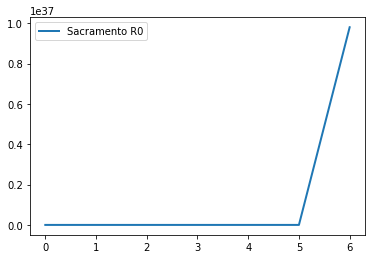

In [46]:
import PIL
import matplotlib.pyplot as plt

x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

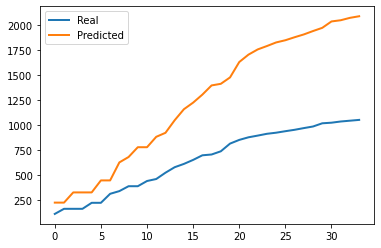

In [49]:
pred_vals = []
for i in range(len(train_past_cases_1d)):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(len(pred_vals))
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

In [51]:
for i,j,k in zip(beta_Sacramento, gamma_Sacramento, R0_Sacramento):
    print(i, j, k)

tensor(1., device='cuda:0') tensor(2.2265e-16, device='cuda:0') tensor(4.4913e+15, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.5813e-19, device='cuda:0') tensor(3.8741e+18, device='cuda:0')
tensor(1., device='cuda:0') tensor(1.1820e-21, device='cuda:0') tensor(8.4599e+20, device='cuda:0')
tensor(1., device='cuda:0') tensor(6.2836e-26, device='cuda:0') tensor(1.5914e+25, device='cuda:0')
tensor(1., device='cuda:0') tensor(2.3755e-28, device='cuda:0') tensor(4.2097e+27, device='cuda:0')
tensor(1., device='cuda:0') tensor(6.2804e-33, device='cuda:0') tensor(1.5923e+32, device='cuda:0')
tensor(1., device='cuda:0') tensor(1.0197e-37, device='cuda:0') tensor(9.8064e+36, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device

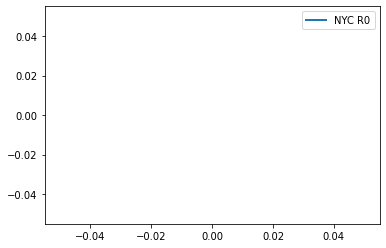

In [57]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

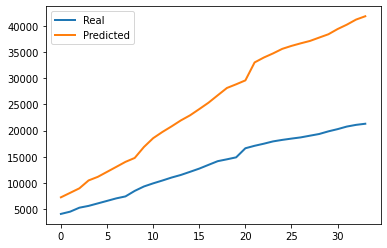

In [59]:
pred_vals_NYC = []
for i in range(len(R0_NYC)):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(len(R0_NYC))
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

In [58]:
for i,j,k in zip(beta_NYC, gamma_NYC, R0_NYC):
    print(i, j, k)

tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(in

## GAT - SIR

In [19]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
        

            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
#        old_eval_err = new_eval_err
#        new_eval_err = np.mean(eval_errs)
#        if old_eval_err <= new_eval_err:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][0])
#                beta_Sacramento.append(vals[202][0])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                I_new, D_new = sir_1d_output(vals, I, D)
#                train_vals.append(I_new)
#            break
#    print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch=0, loss=3.625, validation loss = 6.414, test loss=7.538, test mse = 1328139.375, test mae = 143.040
epoch=1, loss=2.515, validation loss = 3.597, test loss=3.902, test mse = 57905.730, test mae = 42.500
epoch=2, loss=1.733, validation loss = 2.053, test loss=2.063, test mse = 22330.891, test mae = 22.573
epoch=3, loss=1.224, validation loss = 1.128, test loss=1.025, test mse = 14337.678, test mae = 14.574
epoch=4, loss=0.906, validation loss = 0.690, test loss=0.568, test mse = 3302.091, test mae = 9.957
epoch=5, loss=0.732, validation loss = 0.482, test loss=0.362, test mse = 3236.597, test mae = 9.140
epoch=6, loss=0.621, validation loss = 0.355, test loss=0.251, test mse = 3303.890, test mae = 8.981
epoch=7, loss=0.541, validation loss = 0.271, test loss=0.190, test mse = 4346.214, test mae = 9.590
epoch=8, loss=0.480, validation loss = 0.216, test loss=0.152, test mse = 5454.673, test mae = 10.301
epoch=9, loss=0.432, validation loss = 0.179, test loss=0.126, test mse = 7198.

epoch=78, loss=0.056, validation loss = 0.019, test loss=0.015, test mse = 1829705.375, test mae = 49.984
epoch=79, loss=0.055, validation loss = 0.019, test loss=0.015, test mse = 1820590.875, test mae = 47.375
epoch=80, loss=0.055, validation loss = 0.018, test loss=0.014, test mse = 1531372.000, test mae = 40.114
epoch=81, loss=0.054, validation loss = 0.017, test loss=0.013, test mse = 9044.791, test mae = 11.259
epoch=82, loss=0.053, validation loss = 0.017, test loss=0.013, test mse = 5571.063, test mae = 9.714
epoch=83, loss=0.053, validation loss = 0.017, test loss=0.012, test mse = 3534.174, test mae = 8.786
epoch=84, loss=0.052, validation loss = 0.016, test loss=0.012, test mse = 2105.562, test mae = 7.907
epoch=85, loss=0.052, validation loss = 0.016, test loss=0.011, test mse = 1669.316, test mae = 7.449
epoch=86, loss=0.051, validation loss = 0.016, test loss=0.011, test mse = 1603.136, test mae = 7.280
epoch=87, loss=0.050, validation loss = 0.015, test loss=0.011, test 

epoch=158, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.931
epoch=159, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.930
epoch=160, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.930
epoch=161, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.929
epoch=162, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.929
epoch=163, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.929
epoch=164, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.928
epoch=165, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.928
epoch=166, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.928
epoch=167, loss=0.037, validation loss = 0.012, test loss=0.009, test mse

KeyboardInterrupt: 

In [20]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(19, len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

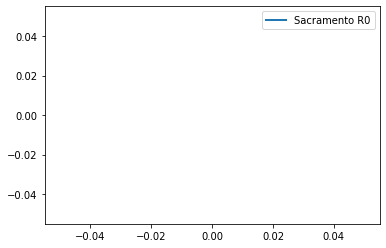

In [21]:
import PIL
import matplotlib.pyplot as plt

x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

In [23]:
pred_vals = []
for i in range(len(train_past_cases_1d)):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(len(pred_vals))
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

IndexError: list index out of range

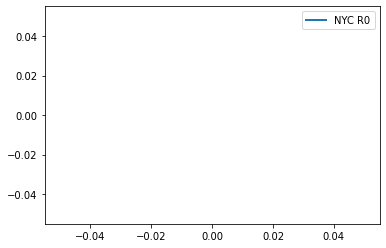

In [68]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

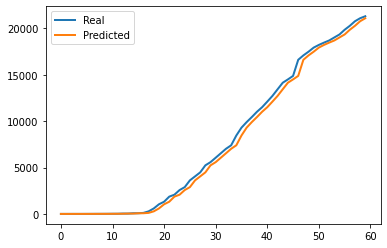

In [69]:
pred_vals_NYC = []
for i in range(79-19):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(60)
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

# 7-day Predictions

## Prepare Data

In [33]:
import numpy as np
import torch as th
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
# for i in range(87, 216):
for i in range(132, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
# for i in range(218, 347):
for i in range(263, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 1 

print('attrs:', attrs.shape)
print('cases:', cases.shape)
print('deaths:', deaths.shape)
print(attrs[0])
print(cases[0])
print(deaths[0])

attrs: torch.Size([3142, 78])
cases: (3142, 84)
deaths: (3142, 84)
tensor([ 4.0641e+01, -7.3955e+01,  4.0651e+01, -7.3955e+01,  1.0000e+00,
         2.5828e+06,  1.2550e+06,  1.3938e+06,  4.7379e-01,  3.5671e+05,
         3.5369e+04,  2.5047e+06,  3.4100e+01,  3.8667e+05,  3.0966e+05,
         6.3500e+02,  9.7000e+00,  1.9580e+02,  1.9500e+01,  1.3841e+01,
         2.3050e+01,  3.5442e+04,  9.3070e+03,  6.0000e+00,  1.2000e+01,
         3.1800e+02,  4.5415e+00,  9.0415e+04,  8.6783e+04,  8.1356e+04,
         7.8035e+04,  7.9604e+04,  7.6959e+04,  8.6716e+04,  8.3968e+04,
         9.6663e+04,  9.9134e+04,  1.0605e+05,  1.1679e+05,  9.7154e+04,
         1.0570e+05,  1.6196e+05,  1.7958e+05,  1.4949e+05,  1.7469e+05,
         6.3789e+04,  7.8116e+04,  5.5241e+04,  6.8866e+04,  6.4628e+04,
         8.8066e+04,  3.5780e+04,  5.8209e+04,  1.2524e+04,  2.8426e+04,
         1.5400e+02,  2.4000e+01,  3.3000e+01,  1.5100e+02,  3.4100e+02,
         4.9300e+02,  1.1160e+03,  2.1390e+03,  2.8520e+0

In [34]:
import torch as th

num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 7
out_size = 7

train_past_cases = []
train_past_deaths = []
train_labels_cases = []
train_labels_deaths = []
for start in range(14):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))

for start in range(14, train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    train_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))

valid_past_cases = []
valid_past_deaths = []
valid_labels_cases = []
valid_labels_deaths = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #valid_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    valid_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    valid_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #valid_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    valid_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))
    
test_past_cases = []
test_past_deaths = []
test_labels_cases = []
test_labels_deaths = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    # test_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    test_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    test_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #test_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    test_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-1:end-1], dtype=th.float32),1))

## Helper Functions

In [35]:
def sir_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D
    I_lst = []
    D_lst = []
    for i in range(7):
        S_new = th.add(S, - th.div(th.mul(beta.view(3142,1), th.mul(S, I)), pop))
        I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
        D_new = th.add(D, th.mul(gamma.view(3142,1), I))
        I_lst.append(I_new)
        D_lst.append(D_new)
        S = S_new
        I = I_new
        D = D_new
    return th.cat(I_lst, dim = 1), th.cat(D_lst, dim = 1)

## Training Loop

### MLP - SIR

In [36]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
            
#        if np.mean(eval_errs) <= 0.054:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                output = sir_output(vals, I, D, labels)
#                train_vals.append(output)
#            break
#        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=3.338, validation loss = 4.170, test loss=4.432, test mse = 7348628.000, test mae = 413.594
epoch=1, loss=3.301, validation loss = 4.113, test loss=4.329, test mse = 7355843.500, test mae = 413.069
epoch=2, loss=3.259, validation loss = 4.048, test loss=4.204, test mse = 7364558.000, test mae = 412.442
epoch=3, loss=3.213, validation loss = 3.973, test loss=4.059, test mse = 7374425.500, test mae = 411.674
epoch=4, loss=3.163, validation loss = 3.890, test loss=3.890, test mse = 7385044.000, test mae = 410.764
epoch=5, loss=3.109, validation loss = 3.796, test loss=3.691, test mse = 7395536.000, test mae = 409.567
epoch=6, loss=3.051, validation loss = 3.691, test loss=3.452, test mse = 7403334.500, test mae = 407.851
epoch=7, loss=2.990, validation loss = 3.571, test loss=3.162, test mse = 7397291.500, test mae = 405.106
epoch=8, loss=2.922, validation loss = 3.432, test loss=2.789, test mse = 7233640.500, test mae = 397.638
epoch=9, loss=2.848, validation 

epoch=77, loss=1.503, validation loss = 1.218, test loss=0.588, test mse = 2758240.750, test mae = 111.109
epoch=78, loss=1.499, validation loss = 1.216, test loss=0.588, test mse = 2675845.750, test mae = 109.878
epoch=79, loss=1.496, validation loss = 1.213, test loss=0.587, test mse = 2595299.250, test mae = 108.647
epoch=80, loss=1.492, validation loss = 1.211, test loss=0.587, test mse = 2515777.000, test mae = 107.419
epoch=81, loss=1.488, validation loss = 1.209, test loss=0.586, test mse = 2436730.250, test mae = 106.193
epoch=82, loss=1.485, validation loss = 1.206, test loss=0.586, test mse = 2357792.250, test mae = 104.969
epoch=83, loss=1.481, validation loss = 1.204, test loss=0.585, test mse = 2278160.250, test mae = 103.740
epoch=84, loss=1.477, validation loss = 1.202, test loss=0.584, test mse = 2197606.500, test mae = 102.513
epoch=85, loss=1.474, validation loss = 1.199, test loss=0.584, test mse = 2115377.250, test mae = 101.282
epoch=86, loss=1.470, validation loss

epoch=155, loss=1.264, validation loss = 1.042, test loss=0.519, test mse = 38458.137, test mae = 47.627
epoch=156, loss=1.262, validation loss = 1.040, test loss=0.518, test mse = 38184.855, test mae = 47.384
epoch=157, loss=1.260, validation loss = 1.038, test loss=0.517, test mse = 37926.285, test mae = 47.145
epoch=158, loss=1.258, validation loss = 1.036, test loss=0.516, test mse = 37680.457, test mae = 46.911
epoch=159, loss=1.256, validation loss = 1.035, test loss=0.515, test mse = 37445.691, test mae = 46.681
epoch=160, loss=1.254, validation loss = 1.033, test loss=0.515, test mse = 37220.363, test mae = 46.456
epoch=161, loss=1.252, validation loss = 1.031, test loss=0.514, test mse = 37003.148, test mae = 46.237
epoch=162, loss=1.251, validation loss = 1.029, test loss=0.513, test mse = 36792.848, test mae = 46.022
epoch=163, loss=1.249, validation loss = 1.028, test loss=0.512, test mse = 36588.324, test mae = 45.812
epoch=164, loss=1.247, validation loss = 1.026, test lo

epoch=236, loss=1.140, validation loss = 0.919, test loss=0.467, test mse = 30833.828, test mae = 36.429
epoch=237, loss=1.139, validation loss = 0.918, test loss=0.467, test mse = 30821.967, test mae = 36.356
epoch=238, loss=1.137, validation loss = 0.917, test loss=0.466, test mse = 30810.398, test mae = 36.284
epoch=239, loss=1.136, validation loss = 0.915, test loss=0.466, test mse = 30799.096, test mae = 36.213
epoch=240, loss=1.135, validation loss = 0.914, test loss=0.465, test mse = 30788.057, test mae = 36.143
epoch=241, loss=1.134, validation loss = 0.913, test loss=0.465, test mse = 30777.283, test mae = 36.073
epoch=242, loss=1.132, validation loss = 0.912, test loss=0.465, test mse = 30766.764, test mae = 36.004
epoch=243, loss=1.131, validation loss = 0.910, test loss=0.464, test mse = 30756.490, test mae = 35.936
epoch=244, loss=1.130, validation loss = 0.909, test loss=0.464, test mse = 30746.447, test mae = 35.869
epoch=245, loss=1.129, validation loss = 0.908, test lo

epoch=317, loss=1.051, validation loss = 0.830, test loss=0.436, test mse = 30371.674, test mae = 32.601
epoch=318, loss=1.050, validation loss = 0.829, test loss=0.436, test mse = 30369.219, test mae = 32.571
epoch=319, loss=1.049, validation loss = 0.828, test loss=0.436, test mse = 30366.803, test mae = 32.542
epoch=320, loss=1.048, validation loss = 0.827, test loss=0.435, test mse = 30364.420, test mae = 32.513
epoch=321, loss=1.047, validation loss = 0.826, test loss=0.435, test mse = 30362.078, test mae = 32.483
epoch=322, loss=1.047, validation loss = 0.825, test loss=0.435, test mse = 30359.768, test mae = 32.455
epoch=323, loss=1.046, validation loss = 0.824, test loss=0.434, test mse = 30357.494, test mae = 32.426
epoch=324, loss=1.045, validation loss = 0.823, test loss=0.434, test mse = 30355.256, test mae = 32.398
epoch=325, loss=1.044, validation loss = 0.822, test loss=0.434, test mse = 30353.053, test mae = 32.369
epoch=326, loss=1.043, validation loss = 0.821, test lo

epoch=398, loss=0.980, validation loss = 0.759, test loss=0.415, test mse = 30256.740, test mae = 30.831
epoch=399, loss=0.980, validation loss = 0.758, test loss=0.415, test mse = 30256.076, test mae = 30.817
epoch=400, loss=0.979, validation loss = 0.757, test loss=0.414, test mse = 30255.420, test mae = 30.803
epoch=401, loss=0.978, validation loss = 0.757, test loss=0.414, test mse = 30254.775, test mae = 30.789
epoch=402, loss=0.977, validation loss = 0.756, test loss=0.414, test mse = 30254.141, test mae = 30.775
epoch=403, loss=0.976, validation loss = 0.755, test loss=0.414, test mse = 30253.523, test mae = 30.762
epoch=404, loss=0.976, validation loss = 0.754, test loss=0.414, test mse = 30252.906, test mae = 30.748
epoch=405, loss=0.975, validation loss = 0.754, test loss=0.413, test mse = 30252.307, test mae = 30.735
epoch=406, loss=0.974, validation loss = 0.753, test loss=0.413, test mse = 30251.713, test mae = 30.722
epoch=407, loss=0.973, validation loss = 0.752, test lo

epoch=479, loss=0.920, validation loss = 0.702, test loss=0.401, test mse = 30224.498, test mae = 29.980
epoch=480, loss=0.919, validation loss = 0.701, test loss=0.401, test mse = 30224.273, test mae = 29.972
epoch=481, loss=0.919, validation loss = 0.700, test loss=0.401, test mse = 30224.053, test mae = 29.964
epoch=482, loss=0.918, validation loss = 0.700, test loss=0.401, test mse = 30223.834, test mae = 29.956
epoch=483, loss=0.917, validation loss = 0.699, test loss=0.401, test mse = 30223.615, test mae = 29.948
epoch=484, loss=0.917, validation loss = 0.698, test loss=0.400, test mse = 30223.398, test mae = 29.940
epoch=485, loss=0.916, validation loss = 0.698, test loss=0.400, test mse = 30223.188, test mae = 29.932
epoch=486, loss=0.915, validation loss = 0.697, test loss=0.400, test mse = 30222.979, test mae = 29.925
epoch=487, loss=0.914, validation loss = 0.696, test loss=0.400, test mse = 30222.773, test mae = 29.917
epoch=488, loss=0.914, validation loss = 0.696, test lo

epoch=560, loss=0.866, validation loss = 0.652, test loss=0.391, test mse = 30212.859, test mae = 29.431
epoch=561, loss=0.866, validation loss = 0.651, test loss=0.391, test mse = 30212.775, test mae = 29.425
epoch=562, loss=0.865, validation loss = 0.651, test loss=0.391, test mse = 30212.693, test mae = 29.420
epoch=563, loss=0.864, validation loss = 0.650, test loss=0.391, test mse = 30212.611, test mae = 29.414
epoch=564, loss=0.864, validation loss = 0.649, test loss=0.390, test mse = 30212.533, test mae = 29.408
epoch=565, loss=0.863, validation loss = 0.649, test loss=0.390, test mse = 30212.453, test mae = 29.403
epoch=566, loss=0.862, validation loss = 0.648, test loss=0.390, test mse = 30212.375, test mae = 29.397
epoch=567, loss=0.862, validation loss = 0.648, test loss=0.390, test mse = 30212.297, test mae = 29.391
epoch=568, loss=0.861, validation loss = 0.647, test loss=0.390, test mse = 30212.217, test mae = 29.386
epoch=569, loss=0.861, validation loss = 0.646, test lo

epoch=641, loss=0.817, validation loss = 0.607, test loss=0.382, test mse = 30208.471, test mae = 29.029
epoch=642, loss=0.816, validation loss = 0.606, test loss=0.382, test mse = 30208.439, test mae = 29.025
epoch=643, loss=0.816, validation loss = 0.606, test loss=0.382, test mse = 30208.412, test mae = 29.021
epoch=644, loss=0.815, validation loss = 0.605, test loss=0.382, test mse = 30208.383, test mae = 29.016
epoch=645, loss=0.814, validation loss = 0.605, test loss=0.382, test mse = 30208.352, test mae = 29.012
epoch=646, loss=0.814, validation loss = 0.604, test loss=0.382, test mse = 30208.326, test mae = 29.008
epoch=647, loss=0.813, validation loss = 0.604, test loss=0.382, test mse = 30208.297, test mae = 29.003
epoch=648, loss=0.813, validation loss = 0.603, test loss=0.382, test mse = 30208.271, test mae = 28.999
epoch=649, loss=0.812, validation loss = 0.603, test loss=0.382, test mse = 30208.242, test mae = 28.995
epoch=650, loss=0.811, validation loss = 0.602, test lo

epoch=722, loss=0.770, validation loss = 0.565, test loss=0.375, test mse = 30207.322, test mae = 28.734
epoch=723, loss=0.769, validation loss = 0.565, test loss=0.375, test mse = 30207.328, test mae = 28.731
epoch=724, loss=0.769, validation loss = 0.564, test loss=0.375, test mse = 30207.328, test mae = 28.729
epoch=725, loss=0.768, validation loss = 0.564, test loss=0.375, test mse = 30207.328, test mae = 28.726
epoch=726, loss=0.768, validation loss = 0.563, test loss=0.375, test mse = 30207.334, test mae = 28.723
epoch=727, loss=0.767, validation loss = 0.563, test loss=0.374, test mse = 30207.336, test mae = 28.720
epoch=728, loss=0.767, validation loss = 0.562, test loss=0.374, test mse = 30207.338, test mae = 28.718
epoch=729, loss=0.766, validation loss = 0.562, test loss=0.374, test mse = 30207.344, test mae = 28.715
epoch=730, loss=0.766, validation loss = 0.561, test loss=0.374, test mse = 30207.344, test mae = 28.712
epoch=731, loss=0.765, validation loss = 0.561, test lo

epoch=803, loss=0.726, validation loss = 0.527, test loss=0.369, test mse = 30208.385, test mae = 28.574
epoch=804, loss=0.725, validation loss = 0.526, test loss=0.369, test mse = 30208.406, test mae = 28.573
epoch=805, loss=0.725, validation loss = 0.526, test loss=0.369, test mse = 30208.430, test mae = 28.572
epoch=806, loss=0.724, validation loss = 0.526, test loss=0.369, test mse = 30208.447, test mae = 28.571
epoch=807, loss=0.724, validation loss = 0.525, test loss=0.369, test mse = 30208.471, test mae = 28.569
epoch=808, loss=0.723, validation loss = 0.525, test loss=0.369, test mse = 30208.490, test mae = 28.568
epoch=809, loss=0.723, validation loss = 0.524, test loss=0.369, test mse = 30208.510, test mae = 28.567
epoch=810, loss=0.722, validation loss = 0.524, test loss=0.369, test mse = 30208.533, test mae = 28.566
epoch=811, loss=0.722, validation loss = 0.523, test loss=0.369, test mse = 30208.555, test mae = 28.565
epoch=812, loss=0.721, validation loss = 0.523, test lo

epoch=884, loss=0.685, validation loss = 0.492, test loss=0.366, test mse = 30210.205, test mae = 28.514
epoch=885, loss=0.684, validation loss = 0.491, test loss=0.366, test mse = 30210.229, test mae = 28.513
epoch=886, loss=0.684, validation loss = 0.491, test loss=0.366, test mse = 30210.248, test mae = 28.513
epoch=887, loss=0.683, validation loss = 0.490, test loss=0.366, test mse = 30210.268, test mae = 28.512
epoch=888, loss=0.683, validation loss = 0.490, test loss=0.366, test mse = 30210.291, test mae = 28.512
epoch=889, loss=0.682, validation loss = 0.490, test loss=0.366, test mse = 30210.312, test mae = 28.511
epoch=890, loss=0.682, validation loss = 0.489, test loss=0.366, test mse = 30210.334, test mae = 28.510
epoch=891, loss=0.681, validation loss = 0.489, test loss=0.366, test mse = 30210.352, test mae = 28.510
epoch=892, loss=0.681, validation loss = 0.488, test loss=0.366, test mse = 30210.373, test mae = 28.509
epoch=893, loss=0.680, validation loss = 0.488, test lo

epoch=965, loss=0.646, validation loss = 0.459, test loss=0.363, test mse = 30211.760, test mae = 28.477
epoch=966, loss=0.646, validation loss = 0.459, test loss=0.363, test mse = 30211.779, test mae = 28.477
epoch=967, loss=0.645, validation loss = 0.459, test loss=0.363, test mse = 30211.791, test mae = 28.476
epoch=968, loss=0.645, validation loss = 0.458, test loss=0.363, test mse = 30211.812, test mae = 28.476
epoch=969, loss=0.645, validation loss = 0.458, test loss=0.363, test mse = 30211.830, test mae = 28.476
epoch=970, loss=0.644, validation loss = 0.458, test loss=0.363, test mse = 30211.850, test mae = 28.475
epoch=971, loss=0.644, validation loss = 0.457, test loss=0.363, test mse = 30211.865, test mae = 28.475
epoch=972, loss=0.643, validation loss = 0.457, test loss=0.363, test mse = 30211.883, test mae = 28.474
epoch=973, loss=0.643, validation loss = 0.456, test loss=0.363, test mse = 30211.898, test mae = 28.474
epoch=974, loss=0.642, validation loss = 0.456, test lo

In [38]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

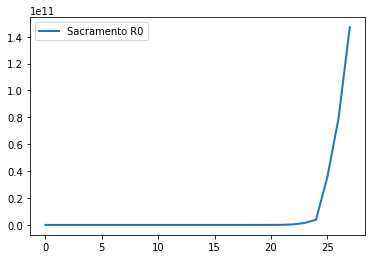

In [39]:
x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

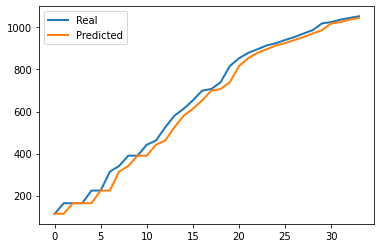

In [40]:
pred_vals = []
for i in range(len(train_past_cases_1d)):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(len(train_past_cases_1d))
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

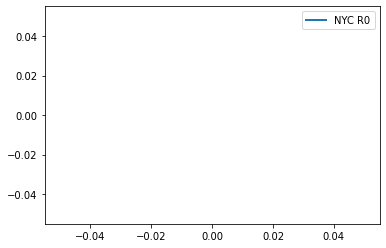

In [41]:
x = range(len(train_past_cases_1d))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

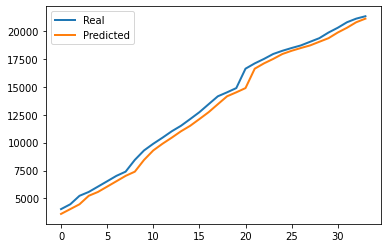

In [42]:
pred_vals_NYC = []
for i in range(len(train_past_cases_1d)):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(len(train_past_cases_1d))
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

### GAT - SIR

In [83]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
            
#        if np.mean(eval_errs) <= 0.054:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                output = sir_output(vals, I, D, labels)
#                train_vals.append(output)
#            break
#        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch=0, loss=1.290, validation loss = 1.034, test loss=1.158, test mse = 2015927.125, test mae = 83.997
epoch=1, loss=1.031, validation loss = 0.541, test loss=0.573, test mse = 30787.713, test mae = 32.163
epoch=2, loss=0.940, validation loss = 0.415, test loss=0.501, test mse = 30350.523, test mae = 30.228
epoch=3, loss=0.886, validation loss = 0.356, test loss=0.482, test mse = 32233.656, test mae = 29.857
epoch=4, loss=0.846, validation loss = 0.320, test loss=0.476, test mse = 31585.117, test mae = 29.550
epoch=5, loss=0.813, validation loss = 0.295, test loss=0.475, test mse = 30804.877, test mae = 29.326
epoch=6, loss=0.786, validation loss = 0.274, test loss=0.476, test mse = 30735.885, test mae = 29.166
epoch=7, loss=0.761, validation loss = 0.260, test loss=0.477, test mse = 30400.367, test mae = 28.986
epoch=8, loss=0.739, validation loss = 0.248, test loss=0.478, test mse = 30253.859, test mae = 28.851
epoch=9, loss=0.719, validation loss = 0.238, test loss=0.479, test mse

epoch=79, loss=0.382, validation loss = 0.174, test loss=0.500, test mse = 30220.656, test mae = 28.406


KeyboardInterrupt: 

In [ ]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(19, len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

In [ ]:
x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(79-19):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(60)
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

In [44]:
for i,j,k in zip(beta_Sacramento, gamma_Sacramento, R0_Sacramento):
    print(i, j, k)

tensor(0.0160, device='cuda:0') tensor(0.0062, device='cuda:0') tensor(2.5541, device='cuda:0')
tensor(0.0081, device='cuda:0') tensor(0.0022, device='cuda:0') tensor(3.6677, device='cuda:0')
tensor(0.0038, device='cuda:0') tensor(0.0009, device='cuda:0') tensor(4.3246, device='cuda:0')
tensor(0.0013, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(8.4636, device='cuda:0')
tensor(0.0005, device='cuda:0') tensor(7.1190e-05, device='cuda:0') tensor(7.3065, device='cuda:0')
tensor(0.0002, device='cuda:0') tensor(1.8216e-05, device='cuda:0') tensor(9.7661, device='cuda:0')
tensor(4.8411e-05, device='cuda:0') tensor(2.2408e-06, device='cuda:0') tensor(21.6038, device='cuda:0')
tensor(1.0758e-05, device='cuda:0') tensor(4.2777e-07, device='cuda:0') tensor(25.1499, device='cuda:0')
tensor(1.4434e-06, device='cuda:0') tensor(3.7484e-08, device='cuda:0') tensor(38.5078, device='cuda:0')
tensor(3.8367e-07, device='cuda:0') tensor(5.4012e-09, device='cuda:0') tensor(71.0348, device='cuda:

In [ ]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

In [ ]:
pred_vals_NYC = []
for i in range(79-19):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(60)
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

In [43]:
for i,j,k in zip(beta_NYC, gamma_NYC, R0_NYC):
    print(i, j, k)

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(na